In [13]:
import torch
import torchvision
from pathlib import Path
from matplotlib import pyplot as plt


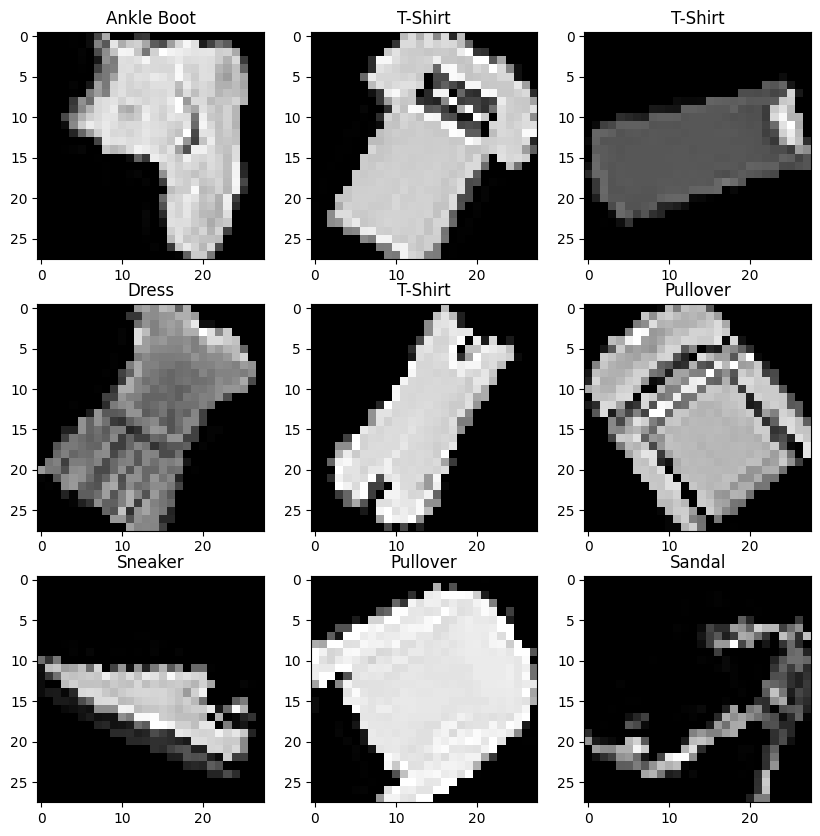

In [80]:
from torch.utils.data import Dataset
from torchvision.transforms import v2

example_dataset = torchvision.datasets.FashionMNIST(
  download=True,
  root=Path('data/fashion'),
  train=True,
  # transform=v2.PILToTensor()
  transform=v2.Compose([
    v2.PILToTensor(),
    v2.RandomRotation(90.0),
  ])
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for index, ax in enumerate(axes.flat):
  image, label = example_dataset[index]
  ax.imshow(image.view(28, 28), cmap='gray')
  ax.set_title(labels_map[label])


In [232]:
train_dataset: Dataset[float] = torchvision.datasets.FashionMNIST(
  download=True,
  root=Path('data/fashion'),
  train=True,
  transform=v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float)
  ]),
  target_transform=torchvision.transforms.Lambda(lambda y: torch.zeros(10).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = torchvision.datasets.FashionMNIST(
  download=True,
  root=Path('data/fashion'),
  train=False,
  transform=v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float)
  ]),
  # target_transform=torchvision.transforms.Lambda(lambda y: torch.zeros(10).scatter_(0, torch.tensor(y), value=1))
)


In [256]:
from torch.utils.data import DataLoader
from torch import nn


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

device = 'mps'

class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.stack = nn.Sequential(
      # nn.Flatten(),
      # nn.Linear(28 * 28, 64),
      nn.Conv2d(1, 2, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      # nn.Flatten(2, 3),
      nn.Flatten(),
      nn.ReLU(),
      # nn.Linear(26 * 26, 512),
      # nn.ReLU(),
      nn.Linear(2 * 13 * 13, 10),
    )

  def forward(self, x):
    logits = self.stack(x)
    return logits

model = Model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

with torch.no_grad():
  print(model.forward(next(iter(train_dataloader))[0].to(device)).shape)
  print(model.forward(train_dataset[0][0].unsqueeze(0).to(device)).shape)


torch.Size([64, 10])
torch.Size([1, 10])


In [257]:
def train_loop():
  size = len(train_dataloader.dataset)

  model.train()

  for batch_index, (x, y) in enumerate(train_dataloader):
    batch_size = x.size(0)

    pred = model(x.to(device))
    loss = loss_fn(pred, y.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_index % 100 == 0:
      loss, current = loss.item(), batch_index * batch_size + len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop():
  model.eval()

  size = len(test_dataloader.dataset)
  batch_count = len(test_dataloader)
  test_loss = 0
  correct_count = 0

  with torch.no_grad():
    for x, y in test_dataloader:
      yd = y.to(device)
      pred = model(x.to(device))
      test_loss += loss_fn(pred, yd).item()
      correct_count += (pred.argmax(1) == yd).type(torch.float).sum().item()

  test_loss /= batch_count
  correct_count /= size

  print(f"Test Error:\n  Accuracy: {(100*correct_count):>0.1f}%\n  Avg loss: {test_loss:>8f} \n")


for t in range(10):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop()
  test_loop()


Epoch 1
-------------------------------
loss: 27.111633  [    1/60000]
loss: 1.252616  [ 6401/60000]
loss: 0.554760  [12801/60000]
loss: 0.927534  [19201/60000]
loss: 0.791414  [25601/60000]
loss: 0.825759  [32001/60000]
loss: 0.669945  [38401/60000]
loss: 0.760350  [44801/60000]
loss: 0.676569  [51201/60000]
loss: 0.571493  [57601/60000]
Test Error:
  Accuracy: 78.0%
  Avg loss: 0.621747 

Epoch 2
-------------------------------
loss: 0.518830  [    1/60000]
loss: 0.557934  [ 6401/60000]
loss: 0.715352  [12801/60000]
loss: 0.679644  [19201/60000]
loss: 0.519857  [25601/60000]
loss: 0.564164  [32001/60000]
loss: 0.585940  [38401/60000]
loss: 0.346877  [44801/60000]
loss: 0.527919  [51201/60000]
loss: 0.410191  [57601/60000]
Test Error:
  Accuracy: 80.6%
  Avg loss: 0.549313 

Epoch 3
-------------------------------
loss: 0.461662  [    1/60000]
loss: 0.562731  [ 6401/60000]
loss: 0.963330  [12801/60000]
loss: 0.549313  [19201/60000]
loss: 0.680776  [25601/60000]
loss: 0.441385  [32001/

In [329]:
# Autoencoder

class Model(nn.Module):
  def __init__(self):
    super().__init__()

    latent_dims = 8

    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28, 512),
      nn.ReLU(),
      nn.Linear(512, latent_dims),
    )

    self.decoder = nn.Sequential(
      nn.Linear(latent_dims, 512),
      nn.ReLU(),
      nn.Linear(512, 28 * 28),
      # nn.ReLU(),
      # nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)

    return self.decoder(self.encoder(x))


In [330]:
model = Model().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_loop():
  model.train()

  for batch_index, (x, _) in enumerate(train_dataloader):
    dx = x.to(device) / 0xff
    decoded = model(dx)
    loss = loss_fn(dx.flatten(1), decoded)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_index % 100 == 0:
      print(f"  loss: {loss.item():>7f}")

for t in range(1):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop()


Epoch 1
-------------------------------
  loss: 0.220433
  loss: 0.025211
  loss: 0.020100
  loss: 0.019779
  loss: 0.020586
  loss: 0.019369
  loss: 0.019785
  loss: 0.018427
  loss: 0.015962
  loss: 0.019158


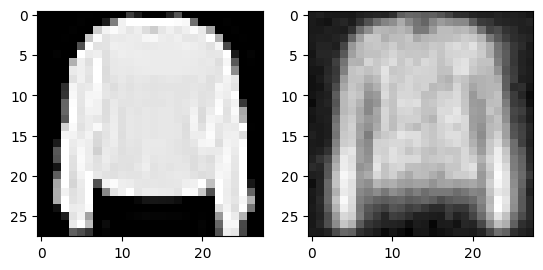

In [340]:
fig, axs = plt.subplots(ncols=2)

with torch.no_grad():
  raw_image = train_dataset[7][0]
  image = raw_image.unsqueeze(0).to(device)
  decoded = model(image).cpu()

  axs[0].imshow(raw_image[0, ...], cmap='gray')
  axs[1].imshow(decoded[0, :].view(28, 28), cmap='gray')
